# ROC-curve for logistic regression model

# Imports

In [1]:
'''
Credit to GitHub user Jaimin09
Link: https://github.com/Jaimin09/Coding-Lane-Assets/tree/main/Logistic%20Regression%20in%20Python%20from%20Scratch
Last accessed: 28/10/2021
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import portablelogresmodel as model

# ! Get dataset
filepath = 'dec_sep_MPHWAE.csv'
df = pd.read_csv(filepath)
df= df.reset_index()

dec_path = 'dec_MPHWA.csv'
dec_df = pd.read_csv(dec_path)
dec_df = dec_df.reset_index()

# Variables for model

In [2]:
X_list = ['ID', 
        'PreviousMedals', 
        'Height_div_avg', 
        'Weight_div_avg', 
        'Age_div_avg'
        ]

Y_list = ['ID', 'MedalEarned']

# Run the model

In [3]:
rng = np.random.default_rng(1)
W_list, B_list = model.RunMore(df, X_list, Y_list, rng, times= 50, iterations= 5000, l_rate= 0.02)


40 runs left.
30 runs left.
20 runs left.
10 runs left.
0 runs left.


# Classify

In [4]:
def Classify(X, W, B, cop):
    lin_func = np.dot(W.T, X) + B # Linear function
    sf = model.Sigmoid(lin_func) # Sigmoid function
    
    # Make sf binary array with data type int64
    sf = sf > cop # Sets sf to one if > 0 or 0 if < 0
    sf = np.array(sf, dtype = 'int64')
    
    return sf

# Alt classify

In [5]:
def AltClassify(df, X, W, B, wg):
    # Calculate predictions
    lf = np.dot(W.T, X) + B # Linear function
    sf = model.Sigmoid(lf) # Sigmoid function
    sf_T = sf.T
    
    # Add predictions to df
    sf_pd = pd.DataFrame(sf_T, columns= ['Prediction'])
    df_sf = pd.concat([df, sf_pd], axis= 1)
    
    # Find highest predictions for each year
    df1 = df_sf.groupby(['Year'])
    df2 = df1.apply(lambda x: x.sort_values(['Prediction'], ascending= False))
    df3 = df2.reset_index(drop= True)
    df4 = df3.groupby('Year').head(wg)
    index_list = df4['index'].tolist()
    
    # Set highest predictions to 1 and rest to 0
    for i in range(len(df_sf)):
        if i in index_list:
            df_sf.at[i, 'Prediction'] = 1
        else:
            df_sf.at[i, 'Prediction'] = 0
    
    sf_T_new = df_sf['Prediction'].to_numpy()
    sf_int = np.array(sf_T_new, dtype = 'int64')
    
    return sf_int

# Accuracy

In [6]:
def Accuracy(sf, Y):
    # 1 = True Pos, 0 = True Neg, -1 = False Neg, 2 = False Pos 
    guesses = sf * 2 - Y
    occurance = [[x, list(guesses[0]).count(x)] for x in set(list(guesses[0]))]
    occ_d = {1:0, 0:0, -1:0, 2:0}
    
    # Assign value to keys e.g. TP : 22
    for i in occurance: 
        occ_d[i[0]] = i[1]
    
    # True Positive, True Negative, False Positive and False Negative
    tp, tn, fp, fn = occ_d[1], occ_d[0], occ_d[2], occ_d[-1]
    
    # Calculate accuracy
    acc = (tp + tn) / (tp + tn + fp + fn)
    
    return acc, occ_d

# Decathlon

In [7]:
def Decathlon(df, W_list, B_list, cop):
    dec_acc_list = []
    dec_occ_list = []
    
    # Reduce and split X and Y dataframes
    X_dec = df[X_list]
    Y_dec = df[Y_list]
    
    # Import and reshape dec data
    X_dec, Y_dec = model.Reshape(X_dec, Y_dec)
    
    # Test parameters on dec
    for i in range(len(W_list)):
        sf = Classify(X_dec, W_list[i], B_list[i], cop)
        da, dod = Accuracy(sf, Y_dec)
        dec_acc_list.append(da)
        dec_occ_list.append(dod)
    
    return dec_acc_list, dec_occ_list

In [8]:
def DecathlonAlt(df, W_list, B_list, wg):
    daal = []
    daol = []
    
    # Reduce and split X and Y dataframes
    X_dec = df[X_list]
    Y_dec = df[Y_list]
    
    # Import and reshape dec data
    X_dec, Y_dec = model.Reshape(X_dec, Y_dec)
    
    for i in range(len(W_list)):
        sf = AltClassify(dec_df, X_dec, W_list[i], B_list[i], wg)
        daa, daod = Accuracy(sf, Y_dec)
        daal.append(daa)
        daol.append(daod)
        
        return daal, daol

# tp and fp

In [9]:
def TPFP(occ_l= []):
    tp,fp,tn,fn = 0,0,0,0 
    
    # Sum up all occurances of False negatives and positives
    # 1 = True Pos, 0 = True Neg, -1 = False Neg, 2 = False Pos 
    for i, occ in enumerate(occ_l):
        tp += occ[1]
        tn += occ[0]
        fn += occ[-1]
        fp += occ[2]
    
    # True positive rate - sensitivity 
    tpr = tp / (tp + fn)
    # False Positive - type 1 error
    fpr = fp / (fp + tn)
    
    return tpr, fpr

# Roc curve

In [10]:
def RocCurve(dec_df, W_list, B_list, name, norm= False, alt= False):
    tp_l = []
    fp_l = []
    
    if norm:
        cop_l = list(range(100, -1, -1))
        
        for i, cop_ in enumerate(cop_l):
            cop = cop_ / 100
            acc_l, occ_l = Decathlon(dec_df, W_list, B_list, cop)
            tpr, fpr = TPFP(occ_l)
            tp_l.append(tpr)
            fp_l.append(fpr)
    
    if alt:
        wg_l = list(range(0, 46, 1))
        
        for i, wg in enumerate(wg_l):
            acc_l, occ_l = DecathlonAlt(dec_df, W_list, B_list, wg)
            tpr, fpr = TPFP(occ_l)
            tp_l.append(tpr)
            fp_l.append(fpr)
    
    # Find smallest distance from optimal
    distance_l = []
    
    for i in range(len(tp_l)):
        distance = abs(math.sqrt((fp_l[i] - 0)**2 + (tp_l[i] - 1)**2))
        distance_l.append(distance)
    
    opt_d = min(distance_l)
    opt_d_ind = distance_l.index(opt_d)
    opt_loc = [tp_l[opt_d_ind] for i in fp_l]
    
    if norm:
        print(f'The optimal cop is: {cop_l[opt_d_ind] / 100}')
        x = np.linspace(0, 1, 100)
    if alt:
        print(f'The optimal wg is: {wg_l[opt_d_ind]}')
        x = np.linspace(0, 1, 10)
    
    # Plot ROC curve
    plt.figure(1)
    plt.plot(fp_l, tp_l)
    plt.plot(x, x, linestyle= ':') # dashed line
    
    plt.plot(fp_l, opt_loc, linestyle= '--', color= 'grey')
    plt.axvline(x= fp_l[opt_d_ind], ymin= 0, ymax= 1, linestyle= '--', color= 'grey')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve: {name}')
    plt.show()
    
    return tp_l, fp_l

The optimal cop is: 0.43


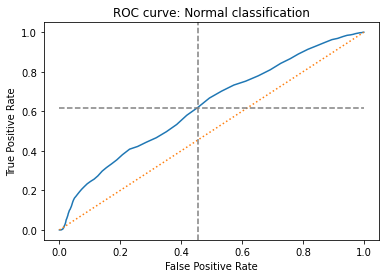

In [11]:
tp_l, fp_l = RocCurve(dec_df, W_list, B_list, 'Normal classification', norm= True)

The optimal wg is: 10


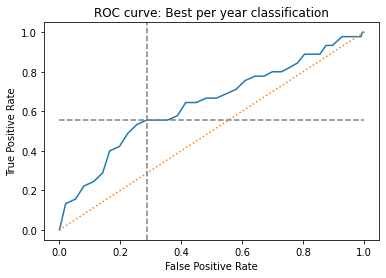

In [12]:
tp_l, fp_l = RocCurve(dec_df, W_list, B_list, 'Best per year classification', alt= True)